In [1]:
from explainers.GNNBoundary.gnn_boundary.models.linear_gcn_classifier import LinearGCNClassifier as LinearGCNClassifier
import torch as torch

In [2]:
import numpy as np

In [3]:
model = LinearGCNClassifier( num_classes=2, node_features=1, hidden_channels=16)
model.load_state_dict(torch.load('model/report_models/counting.pt'))

<All keys matched successfully>

In [4]:
from graph_generation.NodeCountGraphs import NodeCountGraphs
import libraries.dataLoaderWrapper as DLW
dataset = DLW.GNNInterpreterLoaderWrapper(NodeCountGraphs(2000).getDataset())
mean_embeds = dataset.mean_embeddings(model)


/home/sobibence/AAU/2_semester/project/GraBaNN/libraries/dataLoaderWrapper.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obj.y = torch.tensor(obj.y, dtype=torch.long)


In [5]:
y = [data.y for data in dataset]
classes = np.unique(y)
class_indexes = []
for c in classes:
    class_indexes.append(np.where(y == c)[0])
class_indexes

[array([   2,    3,    4, ..., 1996, 1998, 1999]),
 array([   0,    1,    6,    7,    8,    9,   12,   14,   15,   18,   25,
          29,   34,   36,   38,   39,   42,   43,   44,   48,   49,   50,
          53,   55,   56,   57,   59,   62,   63,   64,   65,   66,   68,
          70,   71,   72,   75,   81,   82,   83,   84,   86,   94,   95,
          99,  102,  104,  105,  106,  109,  111,  116,  118,  119,  121,
         122,  123,  124,  129,  130,  131,  133,  134,  136,  137,  138,
         141,  148,  149,  150,  152,  157,  158,  159,  160,  165,  168,
         171,  172,  176,  180,  181,  183,  184,  185,  186,  188,  189,
         190,  191,  193,  194,  201,  209,  212,  213,  214,  217,  220,
         223,  224,  228,  229,  232,  233,  237,  238,  245,  246,  249,
         251,  252,  253,  254,  255,  256,  257,  264,  265,  269,  270,
         272,  274,  277,  278,  279,  281,  282,  286,  290,  292,  293,
         296,  297,  300,  303,  308,  309,  312,  314,  317,

In [6]:

trainers = {}

In [11]:
from explainers.gnninterpreter import *
c = 0

trainers[c] = Trainer(
            sampler=(s := GraphSampler(
                max_nodes=8,
                temperature=0.15,
                learn_node_feat=False
            )),
            discriminator=model,
            criterion=WeightedCriterion([
                dict(key="logits", criterion=ClassScoreCriterion(class_idx=c, mode='maximize'), weight=2),
                #dict(key="logits", criterion=ClassScoreCriterion(class_idx=, mode='minimize'), weight=5),
                dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[c]), weight=1),
                dict(key="logits", criterion=MeanPenalty(), weight=1),
                dict(key="omega", criterion=NormPenalty(order=1), weight=1),
                dict(key="omega", criterion=NormPenalty(order=2), weight=1),
                #dict(key="xi", criterion=NormPenalty(order=1), weight=0),
                #dict(key="xi", criterion=NormPenalty(order=2), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
                # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
                dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=2),
            ]),
            optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
            scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
            dataset=dataset,
            budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
            target_probs={c: (0.9, 1)},
            k_samples=16
        )
trainers[c].train(4000)

  0%|          | 0/4000 [00:00<?, ?it/s]

True

n=10 m=13
logits=[0.9054977893829346, -0.5664262771606445]
probs=[0.8133496642112732, 0.1866503357887268]


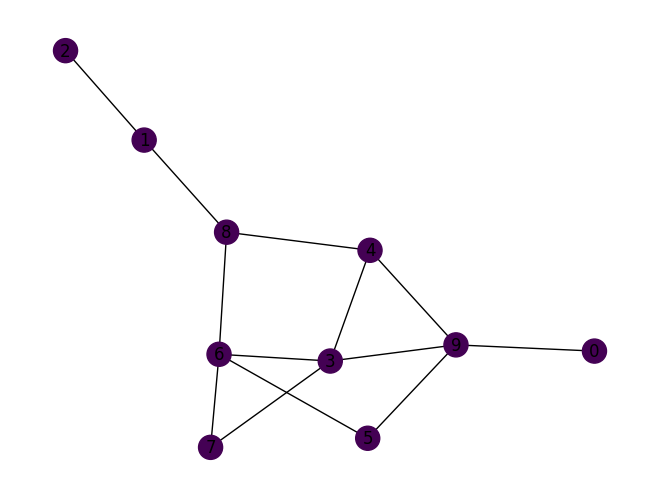

(<networkx.classes.graph.Graph at 0x7f30c073c910>,
 {'n': 10,
  'm': 13,
  'logits': [0.9054977893829346, -0.5664262771606445],
  'probs': [0.8133496642112732, 0.1866503357887268]})

In [8]:
trainers[1].evaluate(threshold=0.5, show=True)

n=6 m=6
logits=[2.9348466396331787, -2.7794926166534424]
probs=[0.9967125654220581, 0.003287486033514142]


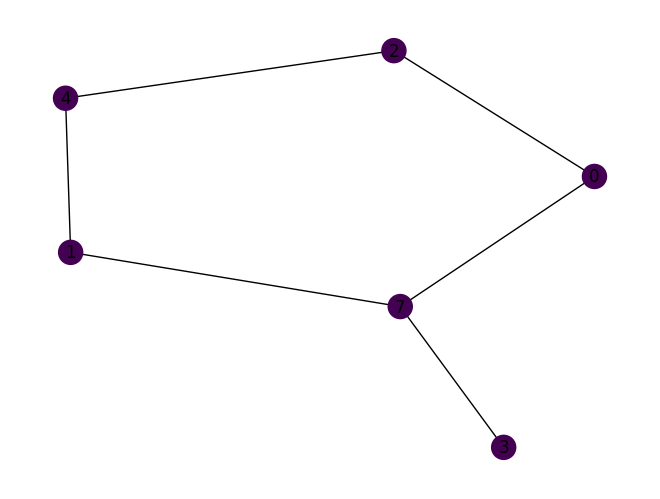

(<networkx.classes.graph.Graph at 0x7f30b06ad0c0>,
 {'n': 6,
  'm': 6,
  'logits': [2.9348466396331787, -2.7794926166534424],
  'probs': [0.9967125654220581, 0.003287486033514142]})

In [19]:
trainers[0].evaluate(threshold=0.5, show=True)